In [1]:
import numpy as np
from numpy.ma import masked_array
import matplotlib.pyplot as plt

from arte.atmo.abstract_phase_generator import PhaseGenerator
from arte.atmo.phase_screen_generator import PhaseScreenGenerator

from arte.utils.radial_profile import computeRadialProfile
from arte.types.mask import CircularMask

In [2]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize], 
                                cmap='twilight', vmin= -24)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, maxValLog=None, red=0.2, mask=None, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-red)), int(imageHalfSizeInPoints*(1+red))]
    imageZoomedLog= np.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    if maxValLog is None:
        maxValLog = np.max(imageZoomedLog)
    imageZoomedLog = imageZoomedLog-maxValLog
    if mask is not None:
        imageZoomedLog = masked_array(imageZoomedLog, mask=1-mask[roi[0]: roi[1], roi[0]:roi[1]])
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

In [3]:
class MyPhaseGenerator(PhaseGenerator):

    def __init__(self,
                 screenSizeInPixels,
                 screenSizeInMeters,
                 outerScaleInMeters,
                 seed:int=None,
                 nSubHarmonics:int=8):
        super().__init__(screenSizeInPixels,screenSizeInMeters,seed,nSubHarmonics)
        self._outerScaleInM = outerScaleInMeters

    def _get_power_spectral_density(self, freqMap, 
                                    min_freq:float=25, max_freq:float=100, damp:float=1e-6):
        mappa = (freqMap**2+ (self._screenSzInM / self._outerScaleInM)**2)**( -11. / 12)
        freqIds = np.ones(freqMap.shape,dtype=bool)
        freqIds[freqMap<min_freq] = 0
        freqIds[freqMap>max_freq] = 0
        mappa[freqIds] *= damp
        mappa[0, 0] = 0
        return mappa
    
    def _get_scaling(self):
        return np.sqrt(0.0228) * self._screenSzInPx**(5. / 6)

In [ ]:
pixPerMeter = 256
D = 1.82
N = 8

Nmeters = N * D
Npix = int(Nmeters * pixPerMeter)

In [5]:
phs = PhaseScreenGenerator(Npix,Nmeters,outerScaleInMeters=25)
phs.rescale_to(15e-2)

In [6]:
# phs.generate_normalized_phase_screens(1)
# 
# screens = phs.get_in_meters()
# plt.figure()
# plt.imshow(screens[0],origin='lower',cmap='RdGy')
# plt.colorbar()

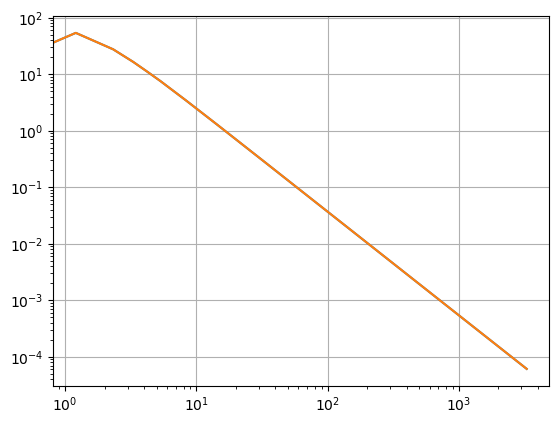

In [7]:
fMap = phs._spatial_frequency(Npix)
psd = phs._get_power_spectral_density(fMap) * phs._get_scaling()

fMap = np.fft.fftshift(fMap)
rad_fMap, _ = computeRadialProfile(fMap, Npix//2, Npix//2)

psd = np.fft.fftshift(psd)
rad_psd, distance = computeRadialProfile(psd, Npix//2, Npix//2)

plt.figure()
plt.plot(distance, rad_psd)
plt.plot(rad_fMap, rad_psd)
plt.grid()
plt.xscale('log')
plt.yscale('log')

(1e-05, 1000.0)

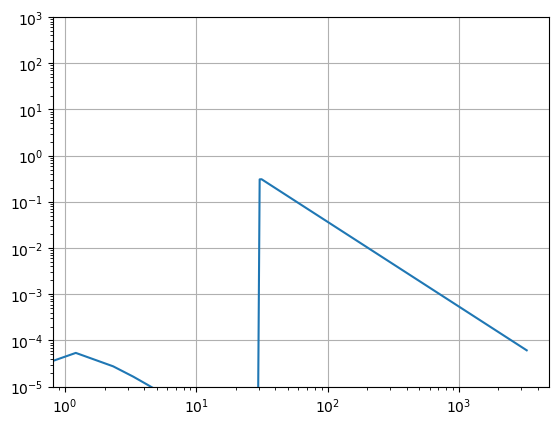

In [8]:
mphs = MyPhaseGenerator(Npix,Nmeters,outerScaleInMeters=25)

fMap = mphs._spatial_frequency(Npix)
psd = mphs._get_power_spectral_density(fMap, min_freq=0.3, max_freq=30, damp=1e-6) * phs._get_scaling()

psd = np.fft.fftshift(psd)
rad_psd, distance = computeRadialProfile(psd, Npix//2, Npix//2)

plt.figure()
plt.plot(rad_fMap, rad_psd)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5,1e+3])

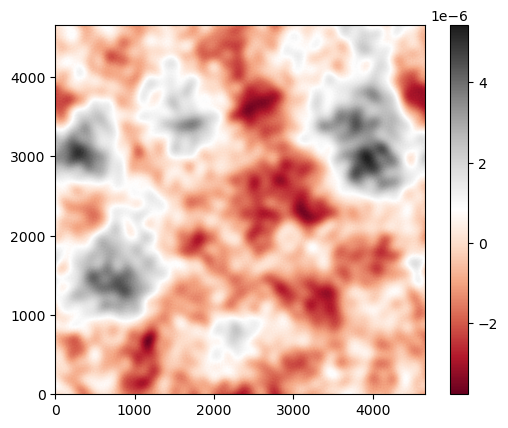

In [9]:
mphs.generate_normalized_phase_screens(1)
screen = mphs._phaseScreens[0]*phs._normalizationFactor/(2*np.pi)*500e-9
plt.figure()
plt.imshow(screen,origin='lower',cmap='RdGy')
plt.colorbar()

In [ ]:
cmask = CircularMask((screen.shape[0],screen.shape[1]),maskRadius=pixPerMeter//2)
phase = screen[~cmask.mask()]

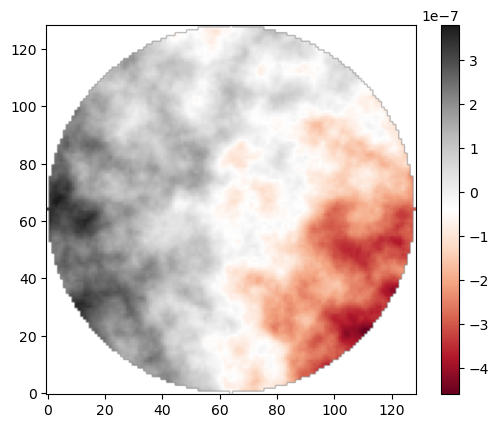

In [ ]:
crop_mask = CircularMask((pixPerMeter+1,pixPerMeter+1),maskRadius=pixPerMeter//2)
image = np.zeros(crop_mask.mask().shape)
image[~crop_mask.mask()] = phase
image = np.reshape(image, crop_mask.mask().shape)

# Remove piston-tip-tilt
X,Y = np.mgrid[0:image.shape[0],0:image.shape[1]]
tilt = X[~crop_mask.mask()]
tip = Y[~crop_mask.mask()]



plt.figure()
plt.imshow(np.ma.masked_array(image,mask=crop_mask.mask()),origin='lower',cmap='RdGy')
plt.colorbar()

In [12]:
def get_coro_psf(phase, cmask, lambdaInM, oversampling:int=4):

    m2rad = 2*np.pi/lambdaInM
    padding_len = int(cmask.mask().shape[0]*(oversampling-1)/2)
    padded_mask = np.pad(cmask.mask(), padding_len, mode='constant', constant_values=1.0)

    image = np.zeros(padded_mask.shape)
    image[~padded_mask] = phase
    phase_2d = np.reshape(image, padded_mask.shape)

    field_amp = 1-padded_mask
    input_field = field_amp  * np.exp(1j*phase_2d*m2rad, dtype=np.complex128)

    focal_field = np.fft.fftshift(np.fft.fft2(input_field))
    psf = abs(focal_field * np.conj(focal_field))

    avg_electric_field = np.sum(input_field * field_amp) / np.sum(field_amp)
    perfect_coro_field = input_field - avg_electric_field * field_amp
    coro_focal_field = np.fft.fftshift(np.fft.fft2(perfect_coro_field))
    coro_psf = abs(coro_focal_field * np.conj(coro_focal_field))

    return psf, coro_psf

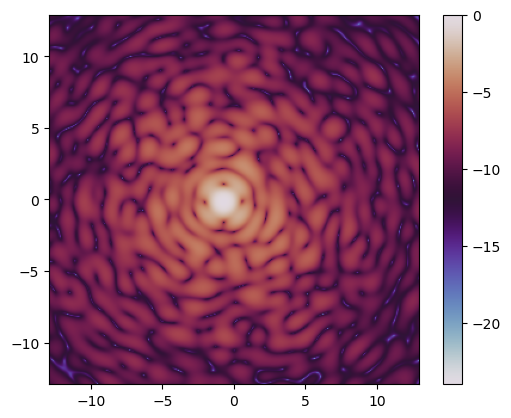

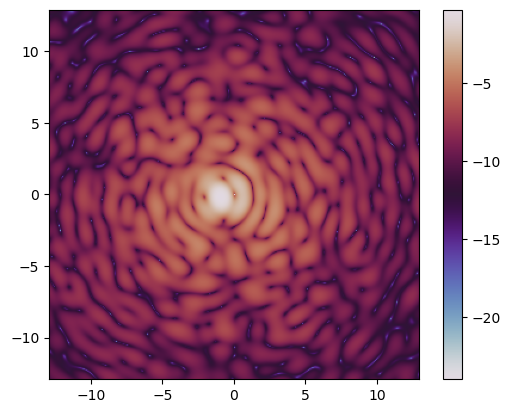

In [13]:
oversampling=12
psf, coro_psf = get_coro_psf(phase, crop_mask, lambdaInM=750e-9, oversampling=oversampling)

plt.figure()
showZoomCenter(psf, 1/oversampling, np.max(np.log(psf)))

plt.figure()
showZoomCenter(coro_psf, 1/oversampling, np.max(np.log(psf)))

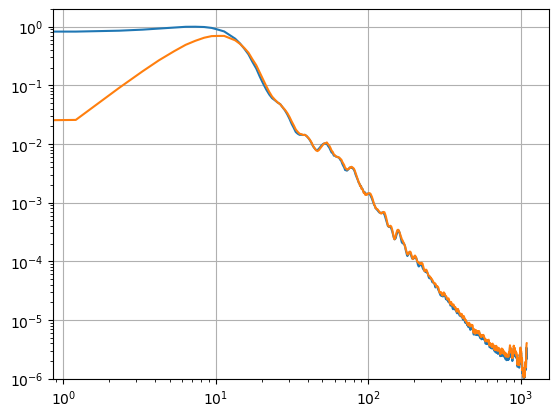

In [ ]:
rad_psf, distance = computeRadialProfile(psf, psf.shape[0]//2, psf.shape[1]//2)
rad_coro_psf, _ = computeRadialProfile(coro_psf, psf.shape[0]//2, psf.shape[1]//2)

plt.figure()
plt.plot(distance, rad_psf/max(rad_psf))
plt.plot(distance, rad_coro_psf/max(rad_psf))
plt.grid()
plt.ylim([1e-6,2])
plt.xscale('log')
plt.yscale('log')